# Validating Strawberry Puree via Infrared Spectral Analysis

<br>
<br>

The purpose of this analysis is to classify strawberry puree as "pure" or "not-pure" by analyzing the frequency domain in the mid-infrared spectrum using Attenuated Total Reflectance sampling.  Not-pure samples have been adulterated with other fruit purees.  

Spectral analysis is a common practice in analyzing fruit and vegetables.  Here, we use a back prop network with 5 hidden layers.

<br>
<br>

~~The Input Layer is made up of 235 nodes.  Each input node represents the strength of a specific wavenumber~~

~~Hidden Layers 1 and 5 have 1000 ReLU nodes~~

~~Hidden Layers 2,3 and 4 have 10000~~

~~The Output Layer is made up of 2 nodes representing unadulerated strawberry puree or the adulterated version.~~

<br>
<br>
<br>

The data used in this notebook came from an original analysis by Holland, Kemsley and Wilson.

<i>"Use of Fourier transform infrared spectroscopy and partial least squares regression for the detection of adulteration of strawberry purees" Holland JK, Kemsley EK, Wilson RH. (1998). Journal of the Science of Food and Agriculture, 76, 263-269</i>

Abstract and Full-text (paywall) are available here: https://europepmc.org/article/agr/ind21806286

The dataset was downloaded from: http://www.timeseriesclassification.com/description.php?Dataset=Strawberry

<br>
<br>
<br>


## Side note:

I deliberately threw the bus at the problem.  There is no need  for so many dense layers.  There is no need to 80 epochs of training.  This was just a feasibility study and needs to be cleaned up.

<br>
<br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
%matplotlib inline

# set sensible default parameters for matplotlib
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

plt.style.use('dark_background')


In [2]:
import torch
print('CUDA available: '.ljust(25), torch.cuda.is_available())
print('CUDA device count: '.ljust(25), torch.cuda.device_count())

current_device = torch.cuda.current_device()
print('Current CUDA Device num: '.ljust(25), current_device)
# torch.cuda.device(current_device)
print('Current CUDA Device: '.ljust(25), torch.cuda.get_device_name(current_device))


CUDA available:           True
CUDA device count:        1
Current CUDA Device num:  0
Current CUDA Device:      GeForce RTX 2070 SUPER


In [3]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
df = pd.read_csv('MIR_Fruit_purees.csv')
df.head()

,Wavenumbers,NON-Strawberry,NON-Strawberry.1,NON-Strawberry.2,NON-Strawberry.3,NON-Strawberry.4,NON-Strawberry.5,NON-Strawberry.6,NON-Strawberry.7,NON-Strawberry.8,...,NON-Strawberry.622,NON-Strawberry.623,NON-Strawberry.624,NON-Strawberry.625,NON-Strawberry.626,NON-Strawberry.627,NON-Strawberry.628,NON-Strawberry.629,NON-Strawberry.630,NON-Strawberry.631
0,899.327,0.002806,0.002637,0.002416,0.002345,0.002303,0.002514,0.002105,0.002018,0.002154,...,0.002539,0.002569,0.002723,0.002542,0.002627,0.002631,0.002730,0.002713,0.002697,0.002789
1,903.187,0.002732,0.002638,0.002480,0.002292,0.002342,0.002488,0.002078,0.001999,0.002165,...,0.002507,0.002569,0.002714,0.002539,0.002629,0.002651,0.002839,0.002779,0.002905,0.003040
2,907.047,0.002661,0.002651,0.002511,0.002249,0.002350,0.002477,0.002077,0.001945,0.002191,...,0.002483,0.002541,0.002740,0.002574,0.002619,0.002696,0.002999,0.002877,0.003277,0.003359
3,910.907,0.002657,0.002757,0.002611,0.002303,0.002419,0.002542,0.002154,0.001964,0.002275,...,0.002563,0.002599,0.002861,0.002664,0.002714,0.002809,0.003259,0.003085,0.003711,0.003796
4,914.767,0.002699,0.003000,0.002802,0.002466,0.002561,0.002713,0.002311,0.002083,0.002470,...,0.002764,0.002806,0.003090,0.002829,0.002939,0.003022,0.003649,0.003419,0.004265,0.004394


<br>
<br>

# Data Wrangling

### Isolate Wavenumbers from the dataframe

In [5]:
# isolate the wavenumbers into a new variable
wavenumbers = df.iloc[:,0]

In [6]:
# remove "Wavenumbers" from the original df prior to Transposing
df.drop(labels='Wavenumbers', axis=1, inplace=True)

<br>

### Transpose the dataframe, and rename the output variable

In [7]:
# Transpose the df and reset index, then rename the old index
df = df.T
df = df.reset_index()
df = df.rename(columns={'index': 'Outcome'})

# shuffle the df so Outcome is at the end 
df = df.iloc[:,1:].join(df.iloc[:,0])

<br>

### Rename the Columns as Wavenumbers

In [8]:
# convert the wavenumbers to columns and round them down to 3 decimal places
cols = [ round(f, 3) for f in wavenumbers.to_list() ]

# add the final column name 'Outcome' to the list and set the df columns 
cols.append('Outcome')
df.columns = cols

# sort the df by Outcome and reset index
df = df.sort_values('Outcome').reset_index(drop=True)

df

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,Outcome
0,0.002806,0.002732,0.002661,0.002657,0.002699,0.002762,0.002749,0.002686,0.002637,0.002617,...,0.000348,0.000216,0.000166,0.000117,0.000087,0.000046,0.000011,0.000009,0.000009,NON-Strawberry
1,0.002637,0.002638,0.002651,0.002757,0.003000,0.003313,0.003412,0.003302,0.003162,0.003060,...,0.000013,0.000006,-0.000005,-0.000005,-0.000006,0.000002,0.000010,0.000005,0.000005,NON-Strawberry.1
2,0.002054,0.002039,0.002030,0.002076,0.002202,0.002350,0.002408,0.002352,0.002276,0.002273,...,0.000466,0.000294,0.000192,0.000125,0.000077,0.000054,0.000035,0.000014,0.000014,NON-Strawberry.10
3,0.002330,0.002332,0.002291,0.002328,0.002482,0.002639,0.002655,0.002555,0.002467,0.002428,...,0.000337,0.000219,0.000111,0.000071,0.000024,0.000052,0.000061,0.000018,0.000018,NON-Strawberry.100
4,0.002562,0.002565,0.002584,0.002691,0.002886,0.003113,0.003233,0.003239,0.003178,0.003077,...,0.000307,0.000199,0.000126,0.000082,0.000051,0.000041,0.000029,0.000009,0.000009,NON-Strawberry.101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,0.002123,0.002187,0.002206,0.002206,0.002351,0.002564,0.002668,0.002598,0.002560,0.002507,...,0.000254,0.000151,0.000096,0.000066,0.000043,0.000038,0.000037,0.000014,0.000014,Strawberry.95
979,0.002384,0.002392,0.002383,0.002491,0.002710,0.002888,0.002948,0.002914,0.002822,0.002701,...,0.000103,0.000054,0.000021,0.000012,0.000005,0.000015,0.000026,0.000013,0.000013,Strawberry.96
980,0.002449,0.002499,0.002506,0.002657,0.002912,0.003137,0.003310,0.003324,0.003217,0.003085,...,0.000103,0.000057,0.000035,0.000020,0.000016,0.000015,0.000009,0.000007,0.000007,Strawberry.97
981,0.002276,0.002358,0.002431,0.002593,0.002830,0.003089,0.003257,0.003285,0.003238,0.003143,...,0.000184,0.000102,0.000060,0.000032,0.000023,0.000019,0.000014,0.000013,0.000013,Strawberry.98


<br>
<br>

### Convert the Dependent Variable to True or False values

Binary classification problem

In [9]:
# replace NON Strawberry outcomes with False
df.loc[:, 'Outcome'] = df.loc[:,'Outcome'].replace(to_replace=r'^NON.*$', value=False, regex=True)

# replace Strawberry with True
df.loc[:, 'Outcome'] = df.loc[:,'Outcome'].replace(to_replace=r'^Straw.*$', value=True, regex=True)

In [10]:
df

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,Outcome
0,0.002806,0.002732,0.002661,0.002657,0.002699,0.002762,0.002749,0.002686,0.002637,0.002617,...,0.000348,0.000216,0.000166,0.000117,0.000087,0.000046,0.000011,0.000009,0.000009,False
1,0.002637,0.002638,0.002651,0.002757,0.003000,0.003313,0.003412,0.003302,0.003162,0.003060,...,0.000013,0.000006,-0.000005,-0.000005,-0.000006,0.000002,0.000010,0.000005,0.000005,False
2,0.002054,0.002039,0.002030,0.002076,0.002202,0.002350,0.002408,0.002352,0.002276,0.002273,...,0.000466,0.000294,0.000192,0.000125,0.000077,0.000054,0.000035,0.000014,0.000014,False
3,0.002330,0.002332,0.002291,0.002328,0.002482,0.002639,0.002655,0.002555,0.002467,0.002428,...,0.000337,0.000219,0.000111,0.000071,0.000024,0.000052,0.000061,0.000018,0.000018,False
4,0.002562,0.002565,0.002584,0.002691,0.002886,0.003113,0.003233,0.003239,0.003178,0.003077,...,0.000307,0.000199,0.000126,0.000082,0.000051,0.000041,0.000029,0.000009,0.000009,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,0.002123,0.002187,0.002206,0.002206,0.002351,0.002564,0.002668,0.002598,0.002560,0.002507,...,0.000254,0.000151,0.000096,0.000066,0.000043,0.000038,0.000037,0.000014,0.000014,True
979,0.002384,0.002392,0.002383,0.002491,0.002710,0.002888,0.002948,0.002914,0.002822,0.002701,...,0.000103,0.000054,0.000021,0.000012,0.000005,0.000015,0.000026,0.000013,0.000013,True
980,0.002449,0.002499,0.002506,0.002657,0.002912,0.003137,0.003310,0.003324,0.003217,0.003085,...,0.000103,0.000057,0.000035,0.000020,0.000016,0.000015,0.000009,0.000007,0.000007,True
981,0.002276,0.002358,0.002431,0.002593,0.002830,0.003089,0.003257,0.003285,0.003238,0.003143,...,0.000184,0.000102,0.000060,0.000032,0.000023,0.000019,0.000014,0.000013,0.000013,True


<br>
<br>
<br>

# EDA on the Spectra

### Plot wavenumbers for Strawberry == True

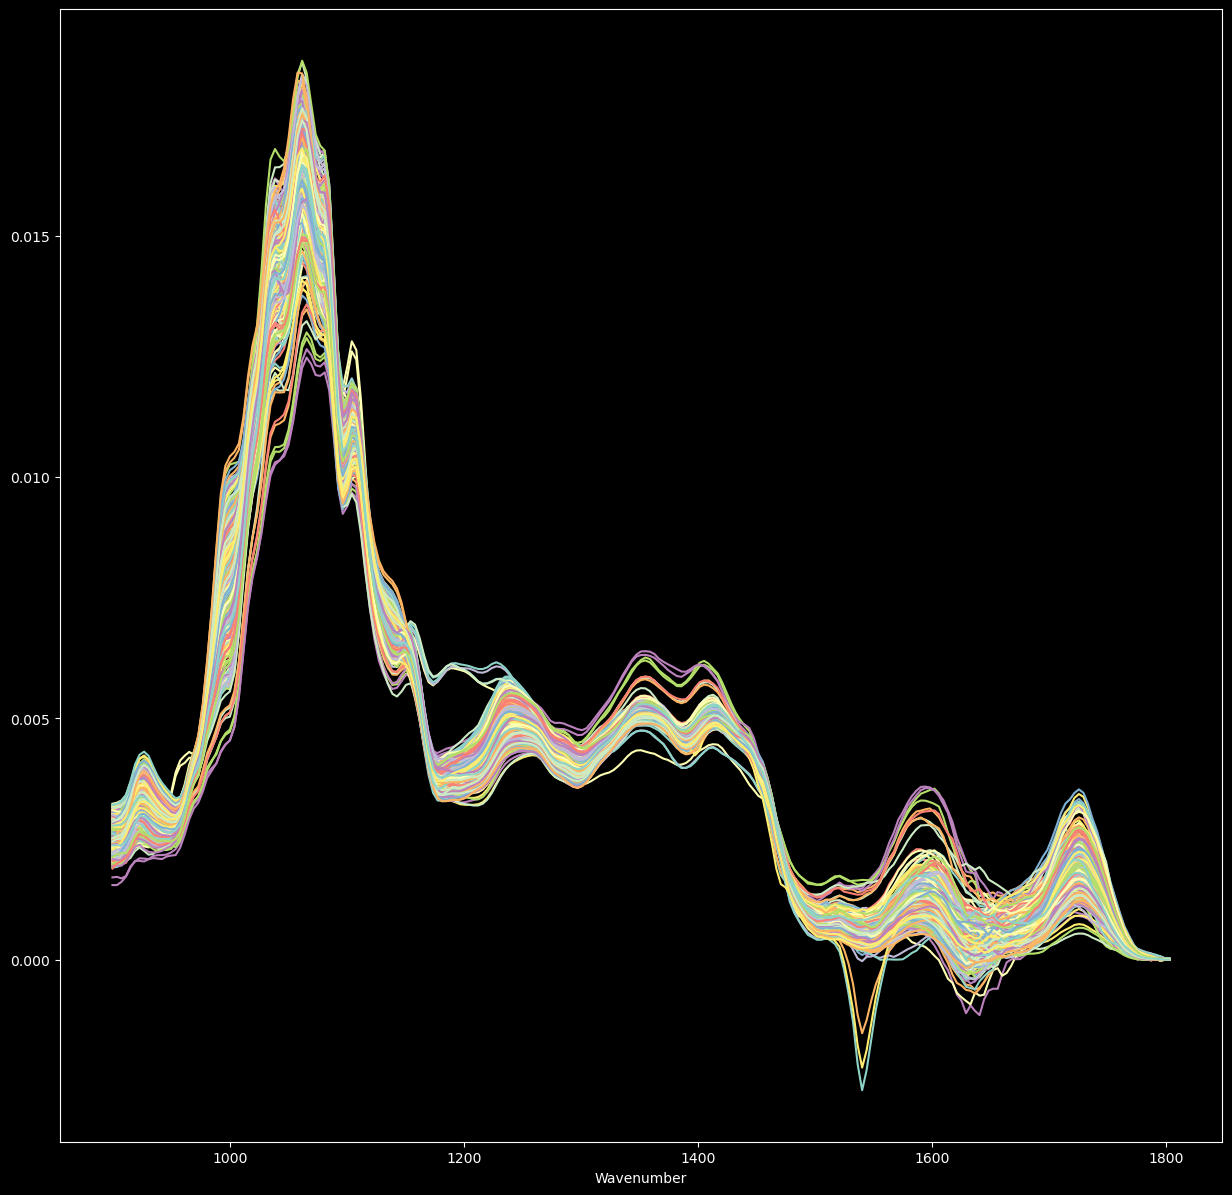

In [11]:
# plot wavenumber vs emission where Strawberry == True
plt.figure(figsize=(15,15))
plt.plot(df.query('Outcome == True').loc[:,df.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>
<br>

### Plot wavenumbers for Strawberry == False

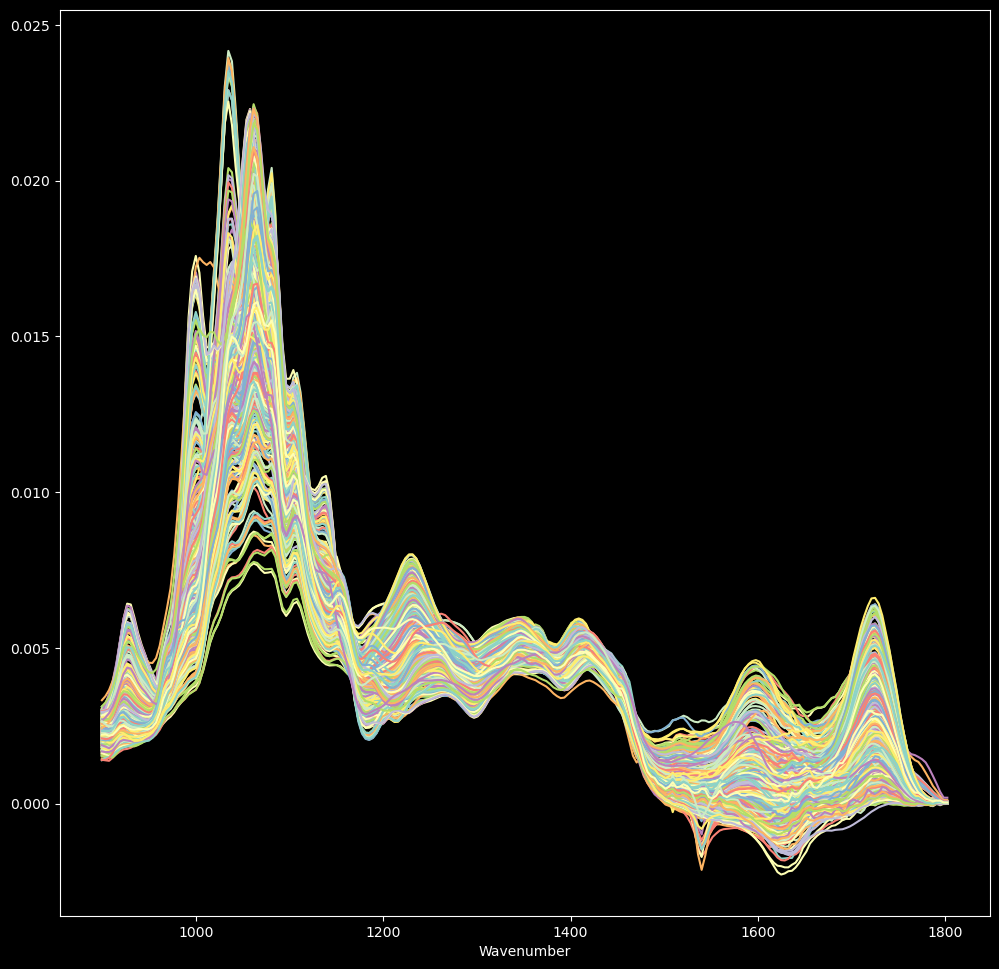

In [12]:
# plot the wavenumber vs emission where Strawberry == False
plt.figure(figsize=(12,12))
plt.plot(df.query('Outcome == False').loc[:,df.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>
<br>

### Split the Data into Training and Validation Sets

In [13]:
# subset 30% of the dataframe to make up the validation set
dfv = df.sample(frac=0.3, replace=False, random_state=42)

# assign the rest as the training set
dft = df.drop(dfv.index)

In [14]:
# Shuffle
dft = dft.sample(len(dft)).reset_index(drop=True)
dfv = dfv.sample(len(dfv)).reset_index(drop=True)

## Imbalanced!

In [15]:
dft.Outcome.value_counts()

False    435
True     253
Name: Outcome, dtype: int64

<br>
<br>

### Fix Imbalance with Oversampling

In [16]:
len(dft)

688

In [17]:
f = dft.query('Outcome == False')
t = dft.query('Outcome == True')

# delta = len(f) - len(t)

sam = t.sample(len(f), replace=True)

new = pd.concat([f, sam], ignore_index=True)

dft = new.sample(len(new), replace=False)  # shuffle
dft = dft.reset_index(drop=True)
dft

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,Outcome
0,0.002840,0.002796,0.002767,0.002819,0.002938,0.003045,0.002993,0.002825,0.002668,0.002570,...,0.000256,0.000226,0.000213,0.000169,0.000130,0.000072,0.000023,1.302000e-05,1.302000e-05,False
1,0.002399,0.002286,0.002244,0.002253,0.002357,0.002468,0.002485,0.002403,0.002339,0.002335,...,0.000077,0.000047,0.000037,0.000027,0.000021,0.000014,0.000006,2.309750e-06,2.309750e-06,False
2,0.002710,0.002730,0.002758,0.002902,0.003210,0.003530,0.003672,0.003625,0.003496,0.003347,...,-0.000013,-0.000013,-0.000028,-0.000024,-0.000027,-0.000002,0.000013,3.788210e-06,3.788210e-06,False
3,0.002288,0.002299,0.002302,0.002373,0.002520,0.002745,0.002820,0.002802,0.002739,0.002642,...,0.000151,0.000084,0.000047,0.000035,0.000028,0.000034,0.000035,1.631530e-05,1.631530e-05,True
4,0.002256,0.002280,0.002327,0.002433,0.002624,0.002878,0.003019,0.003025,0.002974,0.002872,...,0.000212,0.000124,0.000073,0.000046,0.000031,0.000023,0.000018,1.217250e-05,1.217250e-05,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,0.002384,0.002391,0.002378,0.002429,0.002587,0.002718,0.002732,0.002655,0.002563,0.002505,...,0.000130,0.000065,0.000042,0.000030,0.000025,0.000017,0.000003,9.480150e-07,9.480150e-07,True
866,0.002491,0.002470,0.002475,0.002555,0.002713,0.002915,0.003009,0.002993,0.002924,0.002834,...,0.000236,0.000149,0.000107,0.000076,0.000052,0.000028,0.000012,6.420440e-06,6.420440e-06,True
867,0.002236,0.002178,0.002137,0.002180,0.002291,0.002409,0.002432,0.002375,0.002317,0.002300,...,0.000520,0.000333,0.000223,0.000140,0.000089,0.000055,0.000024,1.053640e-05,1.053640e-05,False
868,0.002517,0.002556,0.002592,0.002737,0.003002,0.003292,0.003465,0.003460,0.003355,0.003228,...,0.000116,0.000064,0.000040,0.000027,0.000023,0.000015,0.000008,7.057780e-06,7.057780e-06,True


### OR Fix Imbalance with Undersampling

In [18]:
# sam= f.sample(len(t))
# new = pd.concat([t, sam])

# df = new.sample(len(new))  # shuffle
# df = df.reset_index(drop=True)
# df

In [19]:
dft.Outcome.value_counts()

False    435
True     435
Name: Outcome, dtype: int64

<br>
<br>

## ~~Normalize the data~~

In [20]:
# Find the maximum value of all the independent variables in the Training Set
# maxval = dft.iloc[:, :-1].max().max()  # max of each column , then max of all columns
# maxval

In [21]:
# Normalize the training set against the maxval and add the output variable back in
# dft_norm = dft.iloc[:, :-1] / maxval
# dft_norm = dft_norm.join(dft.iloc[:, -1])

# dft_norm

In [22]:
# Normalize the validation set against the maxval and add the output variable back in
# We use the same maxval of the training set to avoid peeking into the future
# dfv_norm = dfv.iloc[:, :-1] / maxval
# dfv_norm = dfv_norm.join(dfv.iloc[:, -1])

# dfv_norm

<br>
<br>

### Plot the Split and Normalized Data

#### Plot the Training Set where Strawberry == True

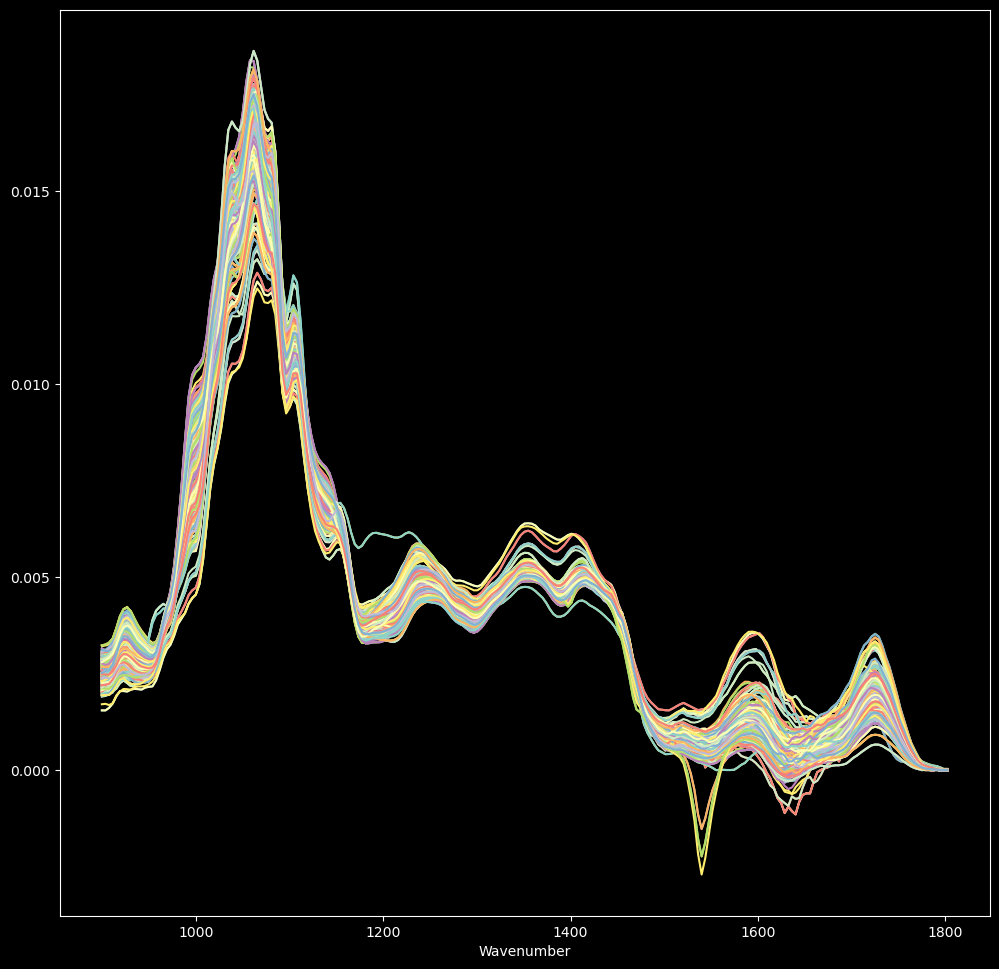

In [23]:
# plot wavenumber vs emission where Strawberry == True
plt.figure(figsize=(12,12))
plt.plot(dft.query('Outcome == True').loc[:,dft.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>

#### Plot the Training Set where Strawberry == False

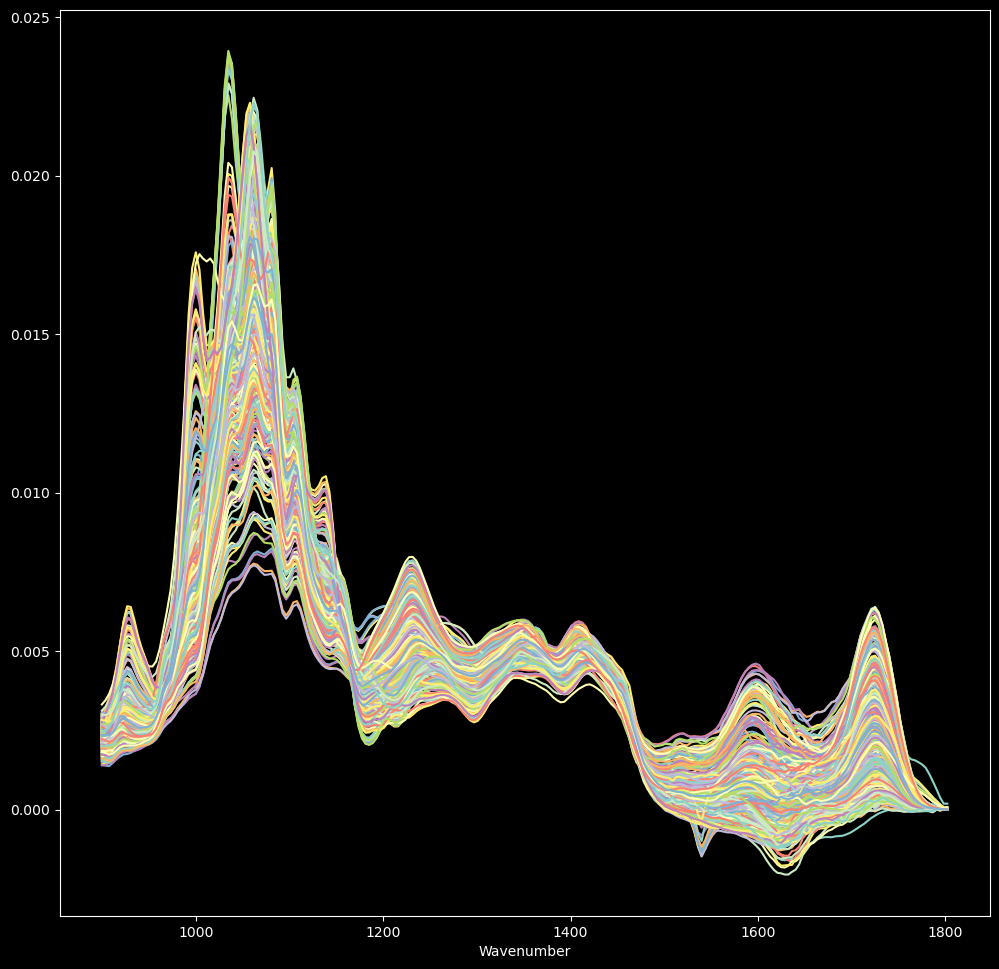

In [24]:
# plot the wavenumber vs emission where Strawberry == False
plt.figure(figsize=(12,12))
plt.plot(dft.query('Outcome == False').loc[:,dft.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>

#### Plot the Validation Set where Strawberry == True

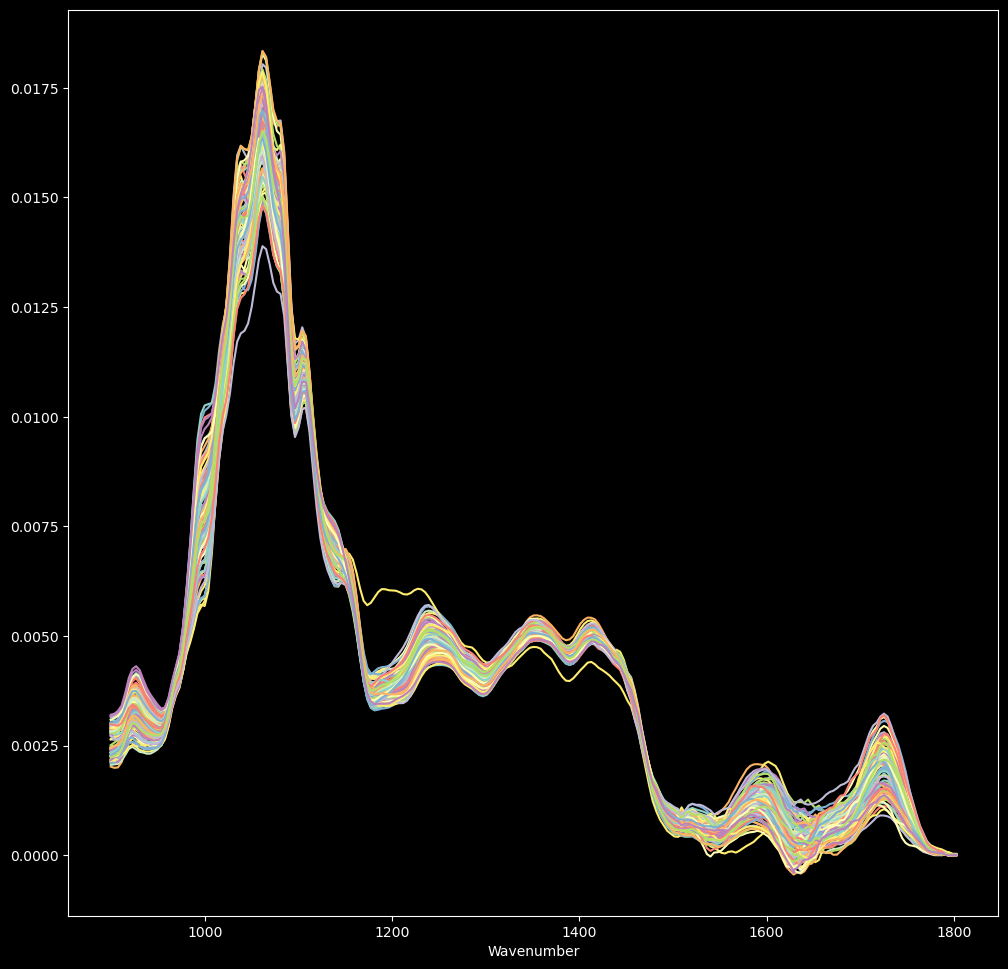

In [25]:
# plot wavenumber vs emission where Strawberry == True
plt.figure(figsize=(12,12))
plt.plot(dfv.query('Outcome == True').loc[:,dfv.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>

#### Plot the Validation Set where Strawberry == False

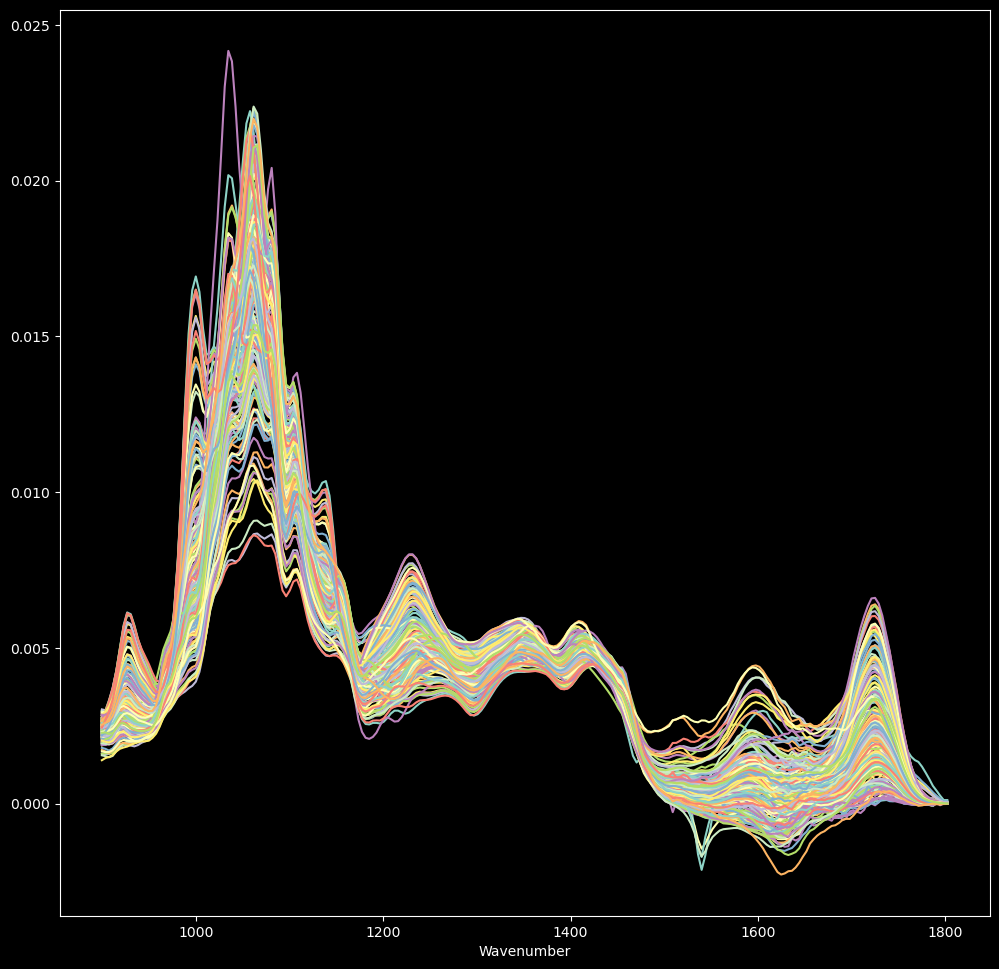

In [26]:
# plot the wavenumber vs emission where Strawberry == False
plt.figure(figsize=(12,12))
plt.plot(dfv.query('Outcome == False').loc[:,dfv.columns != 'Outcome'].T)
plt.xlabel('Wavenumber');

<br>
<br>
<br>

## Preprocessing to make it easier to see errors visually

In [27]:
dfv.sort_values('Outcome', inplace=True)
dfv

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,Outcome
0,0.002072,0.002076,0.002103,0.002193,0.002370,0.002607,0.002730,0.002707,0.002632,0.002582,...,0.000283,0.000176,0.000114,0.000073,0.000043,0.000027,1.380060e-05,4.442260e-06,4.442260e-06,False
168,0.002234,0.002156,0.002101,0.002113,0.002197,0.002286,0.002338,0.002284,0.002247,0.002273,...,0.000430,0.000285,0.000161,0.000118,0.000080,0.000055,3.224470e-05,-5.999110e-07,-5.999110e-07,False
169,0.002466,0.002447,0.002415,0.002477,0.002639,0.002799,0.002844,0.002762,0.002675,0.002646,...,0.000361,0.000241,0.000171,0.000117,0.000080,0.000052,2.783400e-05,1.308090e-05,1.308090e-05,False
170,0.002118,0.002064,0.001979,0.002059,0.002201,0.002357,0.002404,0.002310,0.002227,0.002193,...,0.000321,0.000199,0.000128,0.000082,0.000058,0.000038,2.588760e-05,1.552500e-05,1.552500e-05,False
171,0.002784,0.002779,0.002827,0.003009,0.003292,0.003624,0.003830,0.003849,0.003761,0.003599,...,0.000076,0.000044,0.000007,0.000002,-0.000008,0.000011,2.208900e-05,6.118120e-06,6.118120e-06,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,0.002818,0.002825,0.002880,0.003017,0.003203,0.003429,0.003591,0.003625,0.003533,0.003374,...,0.000223,0.000140,0.000102,0.000067,0.000050,0.000027,8.214620e-06,6.747010e-06,6.747010e-06,True
211,0.003006,0.002973,0.002936,0.003012,0.003242,0.003460,0.003528,0.003473,0.003338,0.003208,...,0.000128,0.000075,0.000046,0.000030,0.000014,0.000012,1.398690e-05,1.251120e-05,1.251120e-05,True
210,0.002981,0.002946,0.002930,0.003017,0.003199,0.003371,0.003433,0.003390,0.003276,0.003153,...,0.000242,0.000153,0.000118,0.000082,0.000067,0.000027,5.779020e-07,5.755170e-06,5.755170e-06,True
57,0.002265,0.002224,0.002188,0.002260,0.002418,0.002561,0.002571,0.002477,0.002402,0.002374,...,0.000127,0.000071,0.000042,0.000023,0.000009,0.000012,4.882320e-06,-3.488820e-07,-3.488820e-07,True


<br>
<br>
<br>
<br>

# Analysis with FastAI

### Define the Learner

In [28]:
from fastai.tabular.all import *

# dls = TabularDataLoaders.from_df(dft, y_names=['Outcome'], procs = [Categorify, FillMissing, Normalize])
dls = TabularDataLoaders.from_df(dft, cont_names=list(dft.columns[:-1]), y_names=['Outcome'])

learn = tabular_learner(dls, lr=1e-3, metrics=[error_rate, accuracy, F1Score(), Precision(), Recall()], 
                        layers=[1000,500]) 



#, layers=[1000,10000,10000,10000,1000])


In [29]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(235, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(235, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=235, out_features=1000, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=1000, out_features=500, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=500, out_features=2, bias=True)
    )
  )
)

<br>
<br>

### ~~Define an Early Callback~~

In [30]:
# early_stop = EarlyStoppingCallback(monitor='error_rate', min_delta=0.1, patience=2)

<br>
<br>

## Fit the model

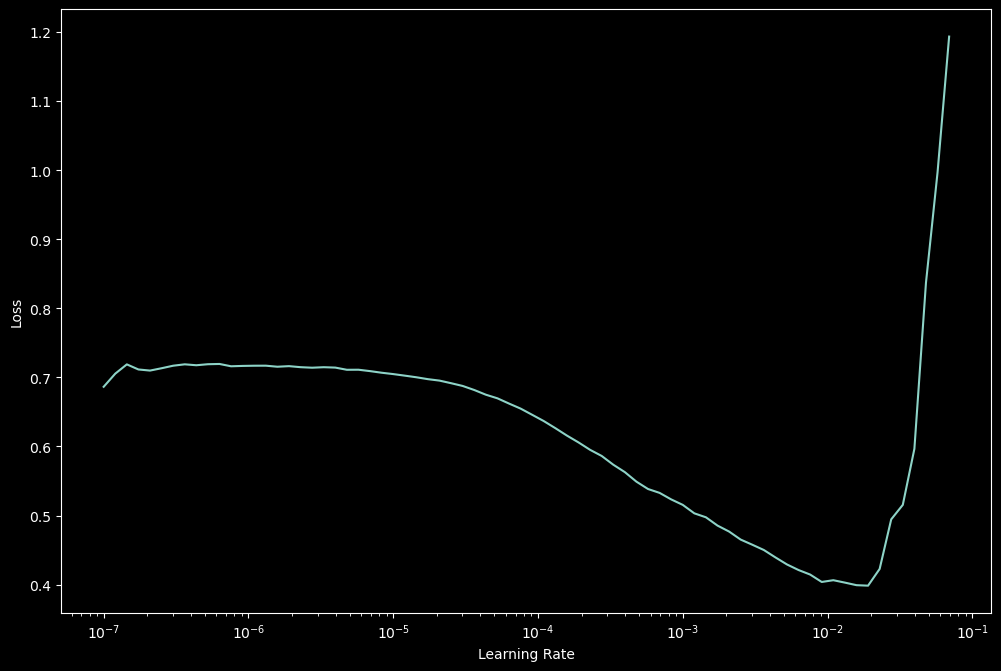

In [31]:
# plot the learning rates vs loss
lr_min,lr_steep = learn.lr_find()

In [32]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.91e-03, steepest point: 3.98e-04


In [33]:
?learn.fit_one_cycle()

Object `learn.fit_one_cycle()` not found.


In [34]:
learn.fit_one_cycle(35)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,0.554664,0.692158,0.465517,0.534483,0.696629,0.534483,1.000000,00:00
1,0.427186,0.891208,0.465517,0.534483,0.696629,0.534483,1.000000,00:00
2,0.334843,1.563808,0.465517,0.534483,0.696629,0.534483,1.000000,00:00
3,0.273243,1.718124,0.465517,0.534483,0.696629,0.534483,1.000000,00:00
4,0.222691,1.099399,0.465517,0.534483,0.696629,0.534483,1.000000,00:00
5,0.185958,0.812881,0.459770,0.540230,0.699248,0.537572,1.000000,00:00
6,0.157458,0.816263,0.436782,0.563218,0.709924,0.550296,1.000000,00:00
7,0.143686,0.818221,0.390805,0.609195,0.732283,0.577640,1.000000,00:00
8,0.136300,0.181864,0.068966,0.931035,0.939394,0.885714,1.000000,00:00
9,0.126126,0.118815,0.040230,0.959770,0.963731,0.930000,1.000000,00:00


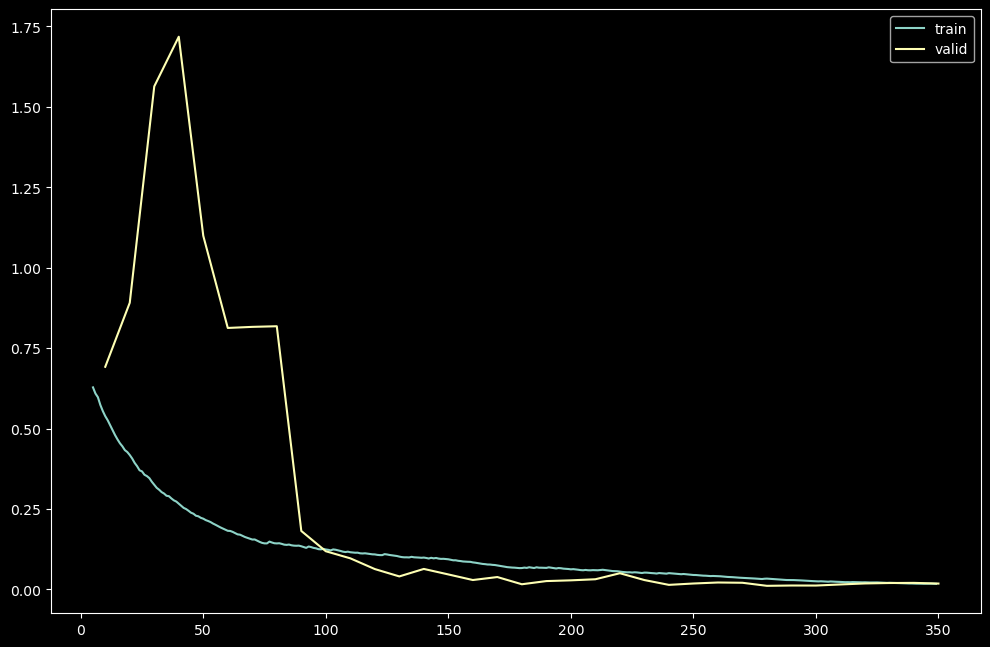

In [35]:
learn.recorder.plot_loss(skip_start=5)

<br>
<br>

### Visualize the Training Set Results


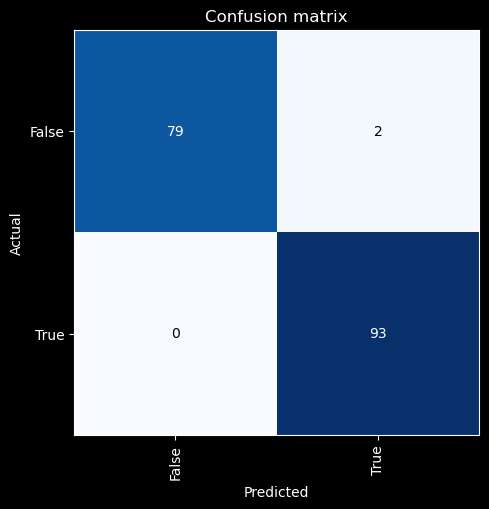

In [36]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5))

<br>
<br>
<br>

# Show Predictions

<br>

### Make a Random Prediction on an Item in the Validation Set

In [37]:
rown = 3
row = dfv.iloc[rown, :-1]

print(f'Actually a Strawberry:           {dfv.iloc[rown, -1]}')
print(f'Predicted to be a Strawberry:    { bool(learn.predict(row=row)[1]) }')
# print(f'Predicted to be a Strawberry:    { bool(learn.predict(row=row)[-1][1].item()) }')

Actually a Strawberry:           False


Predicted to be a Strawberry:    False


<br>
<br>
<br>

## Iteratively Predict Over the Entire Validation Set (Manually)

In [38]:
TP = 0
TN = 0
FP = 0
FN = 0

print('\n    Showing only Errors\n')
print('idx'.rjust(4) + '    ' + 'Actual'.ljust(6) + '   Predicted' )

for i in range(len(dfv)):
    actual = dfv.iloc[i, -1]
    with learn.no_bar():
        predicted = bool(learn.predict(row=dfv.iloc[i, :-1])[1].item())
    
    if(actual != predicted):
        print(f'{str(i).rjust(4)}    {str(actual).ljust(6)}   {predicted}')
    
    if (predicted == True):
        if (actual == True): TP += 1
        else: FP += 1
            
    if (predicted == False):
        if (actual == False): TN += 1
        else: FN += 1
        
print("\n")
print(f'True Positive={TP}')
print(f'True Negative={TN}')
print(f'False Positive={FP}')
print(f'False Negative={FN}');


    Showing only Errors

 idx    Actual   Predicted
  54    False    True
  95    False    True
 119    False    True


True Positive=98
True Negative=194
False Positive=3
False Negative=0


<br>
<br>
<br>

# Score the Predictions (FastAI Version)

In [39]:
accuracy = (TP + TN) / len(dfv)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F1 = (2 * precision * recall) / (precision + recall)

print('\nFastAI Predictions: \n')
print(f'Accuracy:    {round(accuracy,4)}')
print(f'Precision:   {round(precision,4)}')
print(f'Recall:      {round(recall,4)}')
print(f'F1 Score:    {round(F1,4)}')


FastAI Predictions: 

Accuracy:    0.9898
Precision:   0.9703
Recall:      1.0
F1 Score:    0.9849


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Let's Play with Tensorflow/Keras!

Here we implement a simple backprop network using Keras.

In [40]:
from sklearn.model_selection import train_test_split
import tensorflow.keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight



In [41]:
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.25)
dft_orig = dft.copy().astype('float32')
dfv_orig = dfv.copy().astype('float32')
# dft = dft_orig.copy().astype('float32')
# dfv = dfv_orig.copy().astype('float32')


scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
dft = scaler_x.fit_transform(dft)
dfv = scaler_x.fit_transform(dfv)
dft = pd.DataFrame(dft, columns=dft_orig.columns)
dfv = pd.DataFrame(dfv, columns=dfv_orig.columns)


In [42]:
dft.Outcome = dft.Outcome.replace({1.0:True, 0.0:False})
dfv.Outcome = dfv.Outcome.replace({1.0:True, 0.0:False})
# display(dft, dfv)

In [43]:
# dft.Outcome = dft.Outcome.replace({True:1, False:0})
# dfv.Outcome = dfv.Outcome.replace({True:1, False:0})

In [44]:

model = Sequential()

# # model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(24, 235, 1)))

# tf.keras.layers.SimpleRNN(100, activation='relu', dropout=0.1, use_bias=False)
# model.add(tf.keras.layers.BatchNormalization())

# tf.keras.layers.SimpleRNN(100, activation='relu', dropout=0.1, use_bias=False)
# model.add(tf.keras.layers.BatchNormalization())

# tf.keras.layers.SimpleRNN(1000, activation='relu', dropout=0.1, use_bias=False)
# model.add(tf.keras.layers.BatchNormalization())

# tf.keras.layers.SimpleRNN(100, activation='relu', dropout=0.1, use_bias=False)
# model.add(tf.keras.layers.BatchNormalization())




# model.add(Dense(100, activation='relu', use_bias=False))
# model.add(tf.keras.layers.BatchNormalization())

# model.add(Dense(100, activation='relu', use_bias=False))
# model.add(tf.keras.layers.BatchNormalization())

# model.add(Dense(100, activation='relu', use_bias=False))
# model.add(tf.keras.layers.BatchNormalization())

# model.add(Dense(100, activation='relu', use_bias=False))
# model.add(tf.keras.layers.BatchNormalization())


# model.add(Dense(100, activation='relu', use_bias=False))
# model.add(tf.keras.layers.BatchNormalization())

# model.add(Dense(100, activation='relu', use_bias=False))
# model.add(tf.keras.layers.BatchNormalization())

model.add(Dense(300, activation='relu', use_bias=False))
model.add(tf.keras.layers.BatchNormalization())



model.add(Dense(300, activation='relu', use_bias=False))
model.add(tf.keras.layers.BatchNormalization())

model.add(Dense(300, activation='relu', use_bias=False))
model.add(tf.keras.layers.BatchNormalization())


model.add(Dense(1, activation='sigmoid')) 
model.build((None, 235))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               70500     
_________________________________________________________________
batch_normalization (BatchNo (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90000     
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90000     
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)               1200      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3

In [45]:
from tensorflow import keras
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=10e-6,
#     decay_steps=10000,
#     decay_rate=0.9)

opt = keras.optimizers.Adam(learning_rate=10e-5)
# model.compile(opt, loss='mean_squared_error', metrics=['accuracy'])
model.compile(opt, loss='binary_crossentropy', metrics=['accuracy'])





# model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])


# model.compile(optimizer='rmsprop', loss='binary_crossentropy')

# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
# model.compile(optimizer='rmsprop',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])


In [46]:
# epochs_hist = model.fit(dft.iloc[:,:-1].values, dft.iloc[:,-1], epochs=14, batch_size=30,  verbose=1, validation_split=0.3)
epochs_hist = model.fit(dft.iloc[:,:-1].values, dft.iloc[:,-1], epochs=35, batch_size=32,  
                        use_multiprocessing=False, verbose=0, validation_split=0.25)


In [47]:
print(epochs_hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


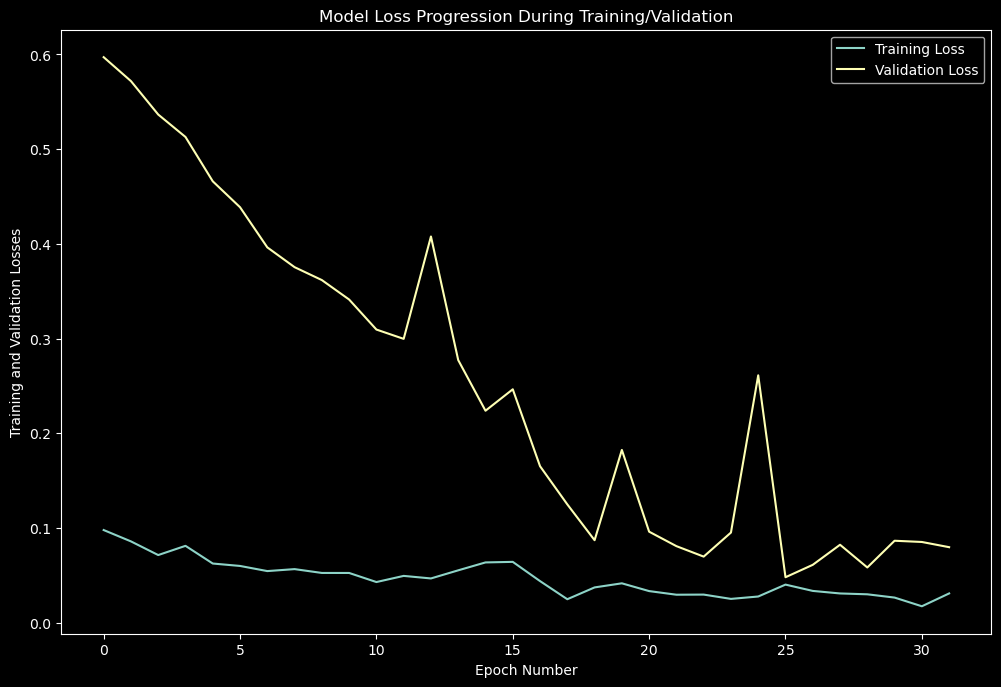

In [48]:
plt.plot(epochs_hist.history['loss'][3:])
plt.plot(epochs_hist.history['val_loss'][3:])

plt.title('Model Loss Progression During Training/Validation')
plt.ylabel('Training and Validation Losses')
plt.xlabel('Epoch Number')
plt.legend(['Training Loss', 'Validation Loss'])

In [49]:
# model.predict(dfv.iloc[6, :-1].values.reshape((1,235)))
model.predict(dfv.iloc[6, :-1].astype('float32').values.reshape((1,235)))

array([[0.01718462]], dtype=float32)

In [50]:
TP = 0
TN = 0
FP = 0
FN = 0

print('\n    Showing only Errors\n')
print('idx'.rjust(4) + '    ' + 'Actual'.ljust(6) + '   Predicted' )

for i in range(len(dfv)):
    actual = bool(dfv.iloc[i, -1])
    predicted = bool(np.round(model.predict(dfv.iloc[i, :-1].astype('float32').values.reshape((1,235))), decimals=0))
    
    if(actual != predicted):
        print(f'{str(i).rjust(4)}    {str(actual).ljust(6)}   {predicted}')
    
    if (predicted == True):
        if (actual == True): TP += 1
        else: FP += 1
            
    if (predicted == False):
        if (actual == False): TN += 1
        else: FN += 1
        
print("\n")
print(f'True Positive={TP}')
print(f'True Negative={TN}')
print(f'False Positive={FP}')
print(f'False Negative={FN}');


    Showing only Errors

 idx    Actual   Predicted
  18    False    True
  20    False    True
  34    False    True
  54    False    True
 119    False    True
 188    False    True
 192    False    True
 275    True     False


True Positive=97
True Negative=190
False Positive=7
False Negative=1


<br>
<br>
<br>

# Score the Predictions (TensorFlow Version)

In [51]:
accuracy = (TP + TN) / len(dfv)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F1 = (2 * precision * recall) / (precision + recall)

print('\nTensorflow Predictions: \n')
print(f'Accuracy:    {round(accuracy,4)}')
print(f'Precision:   {round(precision,4)}')
print(f'Recall:      {round(recall,4)}')
print(f'F1 Score:    {round(F1,4)}')


Tensorflow Predictions: 

Accuracy:    0.9729
Precision:   0.9327
Recall:      0.9898
F1 Score:    0.9604


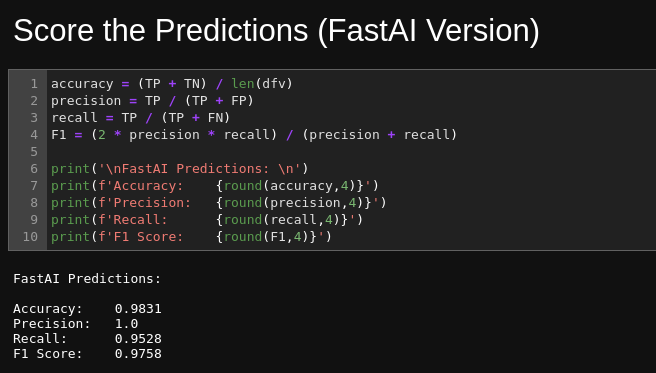

This is a screenshot from the previous analysis with FastAI (earlier in this notebook)